# *Portfolio Optimization Project Using Modern Portfolio Theory (MPT) and Markowitz Model

Goal: Constructing a moderately aggressive, risk-aware portfolio for a long-term investor seeking stable returns with exposure to growth.

Importing Required liabraries 

In [1]:

import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
import time  # for handling rate limits



# Section 1: Defining Tickers and Time Range 

In [2]:
#Defining the list of tickers for my choosen asstes (EFTs+Stocks)
tickers = ["SPY", "AGG", "EFA", "MSFT", "JPM", "NVDA", "JNJ", "PG"]

In [3]:
#Setting the end date to today
end_date = datetime.today()

In [4]:
#Setting the start date to 5 years ago
start_date= end_date - timedelta(days = 5*365)
print(start_date)

2020-10-07 14:36:22.611366


# Section 2: Downloading adjusted close price 

In [5]:
#Downnloading close price for all tickers at once
adj_close_df = pd.DataFrame()

In [6]:
!pip install pandas-datareader

In [7]:
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date,  auto_adjust=False)
    adj_close_df[ticker]=data["Adj Close"]
    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
#displaying data frame
print(adj_close_df)

                   SPY         AGG        EFA        MSFT         JPM  \
Date                                                                    
2020-10-07  317.677246  101.870865  55.868362  201.190353   88.016106   
2020-10-08  320.492645  102.000885  56.256813  201.909485   89.825302   
2020-10-09  323.354614  102.026878  56.697056  206.924088   89.313431   
2020-10-12  328.556580  102.226212  57.025089  212.283920   90.407799   
2020-10-13  326.412476  102.252220  56.386299  213.683838   88.942772   
...                ...         ...        ...         ...         ...   
2025-09-30  666.179993   99.925003  93.370003  517.950012  315.429993   
2025-10-01  668.450012  100.180000  94.139999  519.710022  310.709991   
2025-10-02  669.219971  100.290001  94.290001  515.739990  307.549988   
2025-10-03  669.210022  100.180000  95.080002  517.349976  310.029999   
2025-10-06  670.869995  100.010002  95.315002  521.859985  311.059998   

                  NVDA         JNJ          PG  
D

In [9]:
# Section 3: Save Adjusted Close Prices to CSV
output_file = "adj_close_prices.csv"
adj_close_df.to_csv(output_file)

print(f"Data saved to {output_file}")

Data saved to adj_close_prices.csv


In [10]:
# Loading the saved CSV file
adj_close_df = pd.read_csv("adj_close_prices.csv", index_col=0, parse_dates=True)

# Section 3: Calculating Lognormal Returns

In [11]:
#Calculating lognormal returns for each ticker 

price_ratio = adj_close_df / adj_close_df.shift(1)  
log_return = np.log(price_ratio)

Dropping any Mssing Values 

In [12]:
log_return=log_return.dropna()

# Section 4 : Calculate Covariance Matrix 

In [13]:
# Calculating covariance 
cov_matrix = log_return.cov()*252
print(cov_matrix)

           SPY       AGG       EFA      MSFT       JPM      NVDA       JNJ  \
SPY   0.029567  0.002033  0.022492  0.034009  0.026576  0.061894  0.007155   
AGG   0.002033  0.003676  0.002354  0.002533 -0.000887  0.003828  0.001362   
EFA   0.022492  0.002354  0.026452  0.022531  0.022844  0.042971  0.006896   
MSFT  0.034009  0.002533  0.022531  0.067228  0.019456  0.085578  0.004154   
JPM   0.026576 -0.000887  0.022844  0.019456  0.063152  0.037368  0.009288   
NVDA  0.061894  0.003828  0.042971  0.085578  0.037368  0.268497 -0.007654   
JNJ   0.007155  0.001362  0.006896  0.004154  0.009288 -0.007654  0.028447   
PG    0.009998  0.001857  0.008663  0.010321  0.007494  0.003053  0.013278   

            PG  
SPY   0.009998  
AGG   0.001857  
EFA   0.008663  
MSFT  0.010321  
JPM   0.007494  
NVDA  0.003053  
JNJ   0.013278  
PG    0.029751  


Confirming log vs. simple return differences are negligible (<0.01%)

In [14]:
# Validating Return Type Assumptions

log_means = log_return.mean()
simple_means = adj_close_df.pct_change().mean()

# Comparing differences
difference = (np.exp(log_means + 0.5*log_return.var()) - 1) - simple_means
print("Difference (%):\n", difference * 100)  # Convert to percentage

if (abs(difference) > 0.0001).any():  # If any difference > 0.01%
    print("[WARNING] Large return-type differences detected for:", 
          difference[difference > 0.0001].index.tolist())
else:
    print("Validation passed: return-type differences < 0.01%")


Difference (%):
 SPY     1.860367e-06
AGG     5.196207e-07
EFA     2.485646e-06
MSFT    4.704860e-06
JPM    -1.941122e-05
NVDA   -1.029621e-04
JNJ     5.987116e-06
PG      1.748114e-05
dtype: float64
Validation passed: return-type differences < 0.01%


# Section 5: Defining Portfolio Performance Metrics 

In [15]:
#calculating the portfolio standard deviation

def standard_deviation (weights, cov_matrix):
    """Annualized portfolio volatility (standard deviation)."""
    variance = weights.T @cov_matrix @weights
    return np.sqrt(variance)

In [16]:
#calculating the expected portfolio return
def expected_return (weights, log_return):
    """Annualized expected portfolio return."""
    return np.sum(log_return.mean()*weights)*252

In [17]:
# calculating sharpe ratio 

def sharpe_ratio(weights, log_return, cov_matrix, risk_free_rate):
    """Risk-adjusted return metric (higher = better)."""
    er = expected_return(weights, log_return)
    sd = standard_deviation(weights, cov_matrix)
    return (er - risk_free_rate) / sd

In [18]:
# Get current 10-year Treasury yield (risk-free proxy)

treasury = yf.Ticker("^TNX") #fetching 10 year US treasury yeild

risk_free_rate = treasury.history(period="1d")['Close'].iloc[-1]/100 # Convert % to decimal

print(f"Risk-Free Rate: {risk_free_rate}")

Risk-Free Rate: 0.041579999923706056


In [19]:
test_weights = np.array([1/len(tickers)] * len(tickers))
print(f"Test Sharpe Ratio: {sharpe_ratio(test_weights, log_return, cov_matrix, risk_free_rate):.2f}")

Test Sharpe Ratio: 0.84


# Section 6: Portfolio Optimization 

In [20]:
# Defining the function to mimimize (negative sharpe ratio)
def negative_sharpe_ratio(weights, log_return, cov_matrix, risk_free_rate):
    """Negative Sharpe ratio for minimization"""
    return -sharpe_ratio(weights, log_return, cov_matrix, risk_free_rate)

In [21]:
#Setting the constarint bounds for optimization

# RULE 1: Weights must sum to 100% (no leftover cash)

constraints = [ # Sum of weights = 100% (fully invested)
               {'type':'eq','fun': lambda weights: np.sum(weights)-1},

               # Tech sector (NVDA + MSFT) < 30% of portfolio
               {'type': 'ineq', 'fun': lambda weights: 0.3 - (weights[tickers.index("NVDA")] + weights[tickers.index("MSFT")])}
]


# Bounds: No asset <5% or >20% (diversification rule)
bounds = [(0.05, 0.20) for _ in range(len(tickers))]


In [22]:
#setting initial weights 

initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


In [23]:

print("Individual weights:", initial_weights)  # Should show [0.125, 0.125, ...] for 8 tickers
print("Sum of weights:", np.sum(initial_weights))  # Must be 1.0

Individual weights: [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
Sum of weights: 1.0


Comparing to Benchmarks 

In [24]:
#Calculating equal-weighted performance for comparison

equal_weights = np.array([1/len(tickers)]*len(tickers))
equal_return = expected_return(equal_weights, log_return)
equal_vol = standard_deviation(equal_weights, cov_matrix)
equal_sharpe = sharpe_ratio(equal_weights, log_return, cov_matrix, risk_free_rate)

In [25]:
#Optimize the weight to maximise Sharpe Ratio
optimized_results=minimize(negative_sharpe_ratio,initial_weights, args= (log_return,cov_matrix,risk_free_rate),method='SLSQP',constraints=constraints,bounds=bounds)

In [26]:
#Getting Optimial weights 
optimal_weights = optimized_results.x

# Section 7: Analyze the optimal Portfolio 

In [27]:
# Print optimal weights
print('optimal_weights:')
for ticker,weight in zip(tickers,optimal_weights):
    print(f'{ticker}:{weight: .2%}')

print()
optimal_portfolio_return= expected_return(optimal_weights,log_return)
optimal_portfolio_volatility= standard_deviation(optimal_weights,cov_matrix)
optimal_sharpe_ratio= sharpe_ratio(optimal_weights,log_return,cov_matrix,risk_free_rate)

print(f"Expected Annual Return : {optimal_portfolio_return: .4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility: .4f}")
print(f"Sharpe Ratio : {optimal_sharpe_ratio: .4f}")

optimal_weights:
SPY: 15.00%
AGG: 5.00%
EFA: 5.00%
MSFT: 10.00%
JPM: 20.00%
NVDA: 20.00%
JNJ: 20.00%
PG: 5.00%

Expected Annual Return :  0.2192
Expected Volatility:  0.1819
Sharpe Ratio :  0.9765


# Section 7:  Visualization 

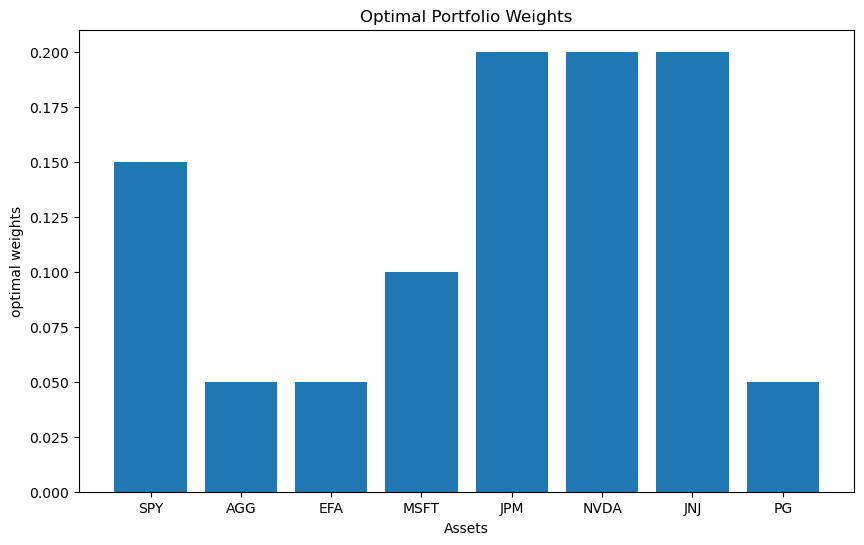

In [28]:
#Displaying the final portfolio graphically 


#importing required liabrary
import matplotlib.pyplot as plt 

#creating a vbar chart of optimal weights 
plt.figure(figsize=(10,6))
plt.bar(tickers,optimal_weights)

#Add labels and a title 
plt.xlabel('Assets')
plt.ylabel('optimal weights')
plt.title("Optimal Portfolio Weights")

#Display 
plt.show()

 


# #### #Section 8: Efficient Frontier 

In [39]:

# Reusing the existing helper functions
def portfolio_return(weights):
    return np.sum(log_return.mean() * weights) * 252

def portfolio_volatility(weights):
    return np.sqrt(weights.T @ cov_matrix @ weights)

# generating points for the frontier
target_returns = np.linspace(0.05, 0.30, 50)  # 5% to 30% annual target return
frontier_vols = []

# Constraints and bounds (same as before)
constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
bounds = [(0.05, 0.20) for _ in range(len(tickers))]

for r in target_returns:
    # Adding return constraint dynamically
    cons = constraints + [{'type': 'eq', 'fun': lambda w, r=r: portfolio_return(w) - r}]
    
    result = minimize(lambda w: portfolio_volatility(w),
                      x0=np.array([1/len(tickers)] * len(tickers)),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=cons)
    
    if result.success:
        frontier_vols.append(result.fun)
    else:
        frontier_vols.append(np.nan)



Plotting Efficeint Frontier 

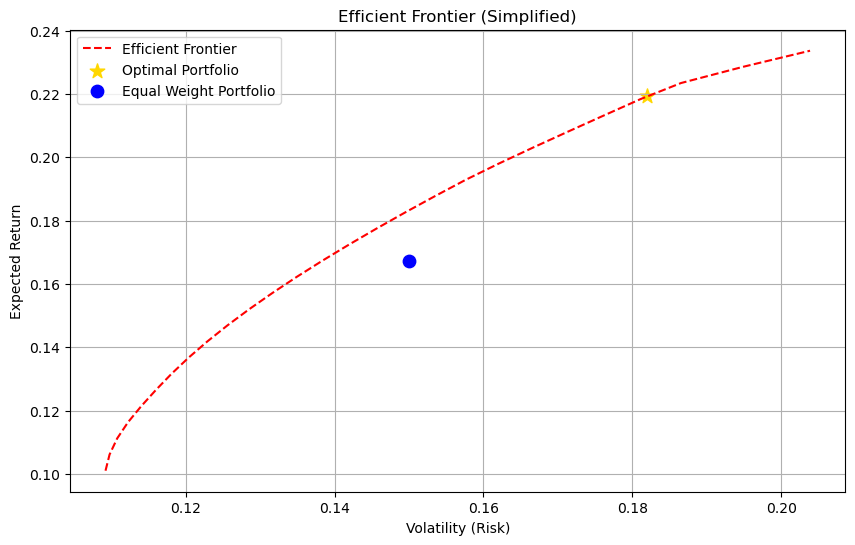

In [40]:

plt.figure(figsize=(10, 6))
plt.plot(frontier_vols, target_returns, 'r--', label='Efficient Frontier')
plt.scatter(optimal_portfolio_volatility, optimal_portfolio_return, color='gold', s=120, marker='*', label='Optimal Portfolio')
plt.scatter(equal_vol, equal_return, color='blue', s=80, label='Equal Weight Portfolio')

plt.title("Efficient Frontier (Simplified)")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.legend()
plt.grid(True)
plt.show()
